In [1]:
import cv2
import numpy as np
import math
import matplotlib.pyplot as plt

In [2]:
def draw_lines(img, points, lines):
    r, c, _ = img.shape
    for r, pt1, pt2 in zip(lines, points[:, 0, :], points[:, 0, :]):
        color = tuple(np.random.randint(0, 255, 3).tolist())
        x0, y0 = map(int, [0, -r[2]/r[1]])
        x1, y1 = map(int, [c, -(r[2] + r[0]*c)/r[1]])
        img = cv2.line(img, (x0,y0), (x1,y1), color, 1)
    return img
def draw_epipole(img, F):
    """绘制极点"""
    U, D, V = np.linalg.svd(F)
    e = V[-1, :]
    h, w = img.shape[:2]
    # 极点在图像内
    if abs(e[2]) > 1e-5:
        x0 = int(e[0]/e[2])
        y0 = int(e[1]/e[2])
        cv2.circle(img, (x0, y0), 5, (0, 255, 0), -1)
    # 极点在图像外，绘制极线
    else:
        x_min, x_max = 0, w-1
        y_min = int(-e[2]/e[1]*x_min - e[0]/e[1])
        y_max = int(-e[2]/e[1]*x_max - e[0]/e[1])
        cv2.line(img, (x_min, y_min), (x_max, y_max), (0, 255, 0), 1)
def normalize(points):
    """坐标归一化"""
    eps = 1e-8
    mean = np.mean(points, axis=0)
    std = np.std(points,axis=0)+eps
    T = np.array([[1/std,0,-mean[0]/std],
                  [0,1/std,-mean[1]/std],
                  [0,0,1]])
    points_norm = np.dot(T, points.T).T
    return points_norm, T

def eight_point_algorithm(pts1, pts2):
    """八点算法"""
    # 归一化坐标
    pts1_norm, T1 = normalize(pts1)
    pts2_norm, T2 = normalize(pts2)
    n = pts1_norm.shape[0]
    # 构建A矩阵
    A = np.zeros((n, 9))
    for i in range(n):
        x, y = pts1_norm[i, :]
        xp, yp = pts2_norm[i, :]
        A[i, :] = np.array([x*xp, x*yp, x, y*xp, y*yp, y, xp, yp, 1])
    # 使用SVD求解最小二乘问题
    _, _, V = np.linalg.svd(A)
    F = V[-1, :].reshape(3, 3)
    # 对F进行奇异值分解，将最小的奇异值置为0
    U, D, V = np.linalg.svd(F)
    D[-1] = 0
    F = np.dot(U, np.dot(np.diag(D), V))
    # 反归一化F矩阵
    F_norm = np.dot(T2.T, np.dot(F, T1))
    return F_norm / F_norm[2, 2]
def drawlines_with_epipole(img1, img2, lines, pts1, pts2, F):
    """绘制极线并加入极点"""
    r, c = img1.shape[:2]
    for r, pt1, pt2 in zip(lines, pts1, pts2):
        color = tuple(np.random.randint(0, 255, 3).tolist())
        x0, y0 = map(int, [0, -r[2]/r[1]])
        x1, y1 = map(int, [c, -(r[2]+r[0]*c)/r[1]])
        img1 = cv2.line(img1, (x0, y0), (x1, y1), color, 1)
        img1 = cv2.circle(img1, tuple(pt1), 5, color, -1)
        img2 = cv2.circle(img2, tuple(pt2), 5, color, -1)
    draw_epipole(img1, F)
    draw_epipole(img2, F)
    return img1, img2

In [3]:
image_l = cv2.imread("D:/test_pic/LEFT.jpg",cv2.IMREAD_COLOR)
image_r = cv2.imread("D:/test_pic/RIGHT.jpg",cv2.IMREAD_COLOR)
img_l_rgb = cv2.cvtColor(image_l, cv2.COLOR_BGR2RGB)
gray_l = cv2.cvtColor(image_l , cv2.COLOR_BGR2GRAY)
img_r_rgb = cv2.cvtColor(image_r, cv2.COLOR_BGR2RGB)
gray_r = cv2.cvtColor(image_r , cv2.COLOR_BGR2GRAY)

In [4]:
sift = cv2.SIFT_create()
kp1, des1 = sift.detectAndCompute(gray_l, None)
kp2, des2 = sift.detectAndCompute(gray_r, None)

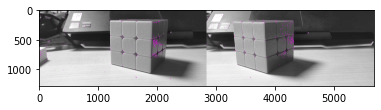

In [5]:
#特征点
img_p1 = cv2.drawKeypoints(gray_l,kp1,gray_l,color=(255,0,255))
img_p2 = cv2.drawKeypoints(gray_r,kp2,gray_r,color=(255,0,255))
hmerge = np.hstack((img_p1, img_p2)) #水平拼接
plt.imshow(hmerge)
plt.show()

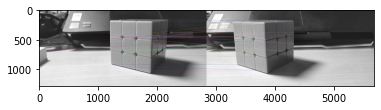

In [6]:
bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)
matches = bf.match(des1, des2)
matches = sorted(matches, key=lambda x: x.distance)

img3 = cv2.drawMatches(gray_l, kp1, gray_r, kp2,matches[:30],None,flags=2)

plt.imshow(img3)
plt.show()

In [7]:
#排除错误点匹配
pts1 = np.float32([kp1[m.queryIdx].pt for m in matches]).reshape(-1,1,2)
pts2 = np.float32([kp2[m.trainIdx].pt for m in matches]).reshape(-1,1,2)

F, mask = cv2.findFundamentalMat(pts1, pts2, cv2.FM_RANSAC)
pts1 = pts1[mask.ravel() == 1]
pts2 = pts2[mask.ravel() == 1]

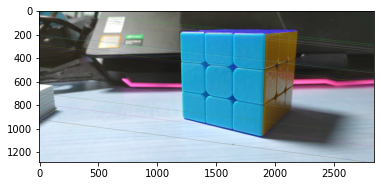

基础矩阵：
[[ 1.11856148e-07 -6.11980007e-07  1.78952129e-03]
 [-2.35834904e-07 -1.80315682e-06 -1.61483564e-02]
 [-2.07500988e-03  1.99007663e-02  1.00000000e+00]]


In [8]:
#八点矩阵
F, mask = cv2.findFundamentalMat(pts1, pts2, cv2.FM_8POINT)
lines1 = cv2.computeCorrespondEpilines(pts2, 2, F)
lines1 = lines1.reshape(-1, 3)
img4 = draw_lines(image_l, pts1, lines1)

plt.imshow(img4)
plt.show()
print("基础矩阵：")
print(F)

IndexError: index 1 is out of bounds for axis 0 with size 1